# Semantic Segmentation

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 71kB 5.1MB/s 
     |████████████████████████████████| 245kB 15.0MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 


In [3]:
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

Version 1.8.0+cu101
CUDA enabled: True


In [4]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive


# Dataset

In [5]:
INPUT_DATA = "/gdrive/My Drive/proj/dataset/semantic_drone_dataset/"
IMAGE_PATH = os.path.join(INPUT_DATA, "original_images/")
MASK_PATH = os.path.join(INPUT_DATA, "label_images_semantic/")

In [6]:
num_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


# Train-Validation-Test Split

In [7]:
data = list(df['id'].values)
total_len = len(data)
random.seed(24)
train_data = random.sample(data, int(0.7 * total_len))
remaining_data = list(set(data) - set(train_data))
validation_data = random.sample(remaining_data, int(0.15 * total_len))
test_data = list(set(remaining_data) - set(validation_data))

In [8]:
train_data = np.array(train_data)
validation_data = np.array(validation_data)
test_data = np.array(test_data)

print('Train Size.     : ', len(train_data))
print('Validation Size : ', len(validation_data))
print('Test Size.      : ', len(test_data))

Train Size.     :  280
Validation Size :  60
Test Size.      :  60


# Visualize Training Image

Image Size (4000, 6000, 3)


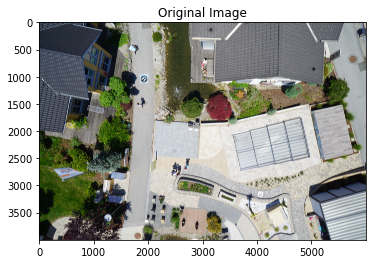

In [11]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
print('Image Size', np.asarray(img).shape)

plt.imshow(img)
plt.title('Original Image')
plt.show()

# Visualize Training Image with Mask

Mask Size (4000, 6000)


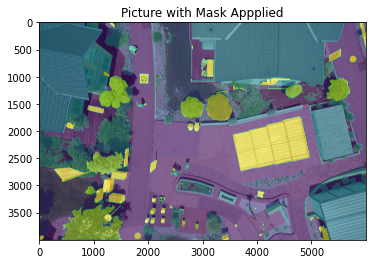

In [12]:
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [ ]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

# Load Datasets

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, train_data, mean, std, t_train, patch=False)
validation_set = DroneDataset(IMAGE_PATH, MASK_PATH, validation_data, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True) 

# Create Model

In [ ]:
model = smp.Unet('resnet50', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


# Evaluation Methods

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def IOU(pred_mask, mask, smooth=1e-10, num_classes=23):
  with torch.no_grad():
    pred_mask = F.softmax(pred_mask, dim = 1)
    pred_mask = torch.argmax(pred_mask, dim = 1)
    pred_mask = pred_mask.contiguous().view(-1)
    mask = mask.contiguous().view(-1)

    iou_per_class = []
    for class_name in range(0, num_classes): #loop per pixel class
      true_class = pred_mask == class_name
      true_label = mask == class_name

      if true_label.long().sum().item() == 0: #no exist label in this loop
        iou_per_class.append(np.nan)
      else:
        intersection = torch.logical_and(true_class, true_label).sum().float().item()
        union = torch.logical_or(true_class, true_label).sum().float().item()

        iou = (intersection + smooth) / (union + smooth)
        iou_per_class.append(iou)
    return np.nanmean(iou_per_class)

# Train Functions

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def fit(epochs, model, train_loader, validation_loader, loss_fn, optimizer, scheduler, patch = False):
  torch.cuda.empty_cache()
  train_losses = []
  validation_losses = []
  validation_iou_scores = []
  validation_accuracies = []
  train_iou = []
  train_accuracies = []
  learning_rates = []
  min_loss = np.inf
  decrease = 1
  not_improve = 0

  model.to(device)
  total_time = time.time()
  
  for epoch in range(epochs):
    epoch_start = time.time()

    train_loss = 0
    iou = 0
    train_accuracy = 0

    # training loop
    model.train()
    for i, data in enumerate(tqdm(train_loader)):

      # training
      image_tiles, mask_tiles = data
      if patch:
        bs, n_tiles, c, h, w = image_tiles.size()
        image_tiles = image_tiles.view(-1,c, h, w)
        mask_tiles = mask_tiles.view(-1, h, w)

      image = image_tiles.to(device)
      mask = mask_tiles.to(device)

      # forward
      output = model(image)
      loss = loss_fn(output, mask)

      # evaluation metrics
      iou += IOU(output, mask)
      train_accuracy += pixel_accuracy(output, mask)

      # backward
      loss.backward()
      optimizer.step() # update weight          
      optimizer.zero_grad() # reset gradient

      # step the learning rate
      learning_rates.append(get_lr(optimizer))
      scheduler.step()

      train_loss += loss.item()

    model.eval()
    validation_loss = 0
    validation_accuracy = 0
    validation_iou = 0

    # validation loop
    for i, data in enumerate(tqdm(validation_loader)):
      image_tiles, mask_tiles = data
      if patch:
        bs, n_tiles, c, h, w = image_tiles.size()
        image_tiles = image_tiles.view(-1,c, h, w)
        mask_tiles = mask_tiles.view(-1, h, w)

      image = image_tiles.to(device)
      mask = mask_tiles.to(device)

      output = model(image)
      
      # evaluation metrics
      validation_iou += IOU(output, mask)
      validation_accuracy += pixel_accuracy(output, mask)

      # loss
      loss = loss_fn(output, mask)
      validation_loss += loss.item()
    
    # mean losses
    train_losses.append(train_loss / len(train_loader))
    mean_validation_loss = validation_loss / len(validation_loader)
    validation_losses.append(mean_validation_loss)

    if mean_validation_loss < min_loss:
      print("Loss Decreasing.. {:.3f} >> {:.3f} ".format(min_loss, mean_validation_loss))
      min_loss = mean_validation_loss
      decrease += 1
    
    if mean_validation_loss > min_loss:
      not_improve += 1
      min_loss = mean_validation_loss
      print(f'Loss Not Decrease for {not_improve} time')
      if not_improve == 6:
          print('Loss not decrease for 6 times, Stop Training')
          break
    #iou
    validation_iou_scores.append(validation_iou / len(validation_loader))
    train_iou.append(iou / len(train_loader))
    train_accuracies.append(train_accuracy / len(train_loader))
    validation_accuracies.append(validation_accuracy / len(validation_loader))
    print("Epoch:{}/{}..".format(epoch+1, epochs),
          "Train Loss: {:.3f}..".format(train_loss / len(train_loader)),
          "Val Loss: {:.3f}..".format(validation_loss / len(validation_loader)),
          "Train mIoU:{:.3f}..".format(iou / len(train_loader)),
          "Val mIoU: {:.3f}..".format(validation_iou / len(validation_loader)),
          "Train Acc:{:.3f}..".format(train_accuracy / len(train_loader)),
          "Val Acc:{:.3f}..".format(validation_accuracy / len(validation_loader)),
          "Time: {:.2f}m".format((time.time() - epoch_start) / 60))
  
  history = {'train_loss' : train_losses, 'val_loss': validation_losses,
               'train_miou' : train_iou, 'val_miou': validation_iou_scores,
               'train_acc' : train_accuracies, 'val_acc': validation_accuracies,
               'lrs': learning_rates}
  print('Total time: {:.2f} m' .format((time.time() - total_time) / 60))
  return history

# Training

In [ ]:
learning_rate = 0.001
epochs = 15
weight_decay = 0.0001

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = epochs, steps_per_epoch = len(train_loader))
history = fit(epochs, model, train_loader, validation_loader, loss_fn, optimizer, sched)
torch.save(model, 'Unet-resnet50.pt')


Loss Decreasing.. inf >> 1.942 
Epoch:1/15.. Train Loss: 2.565.. Val Loss: 1.942.. Train mIoU:0.081.. Val mIoU: 0.126.. Train Acc:0.352.. Val Acc:0.623.. Time: 14.20m



Loss Decreasing.. 1.942 >> 1.462 
Epoch:2/15.. Train Loss: 1.740.. Val Loss: 1.462.. Train mIoU:0.126.. Val mIoU: 0.136.. Train Acc:0.606.. Val Acc:0.635.. Time: 4.23m



Loss Decreasing.. 1.462 >> 1.107 
Epoch:3/15.. Train Loss: 1.442.. Val Loss: 1.107.. Train mIoU:0.131.. Val mIoU: 0.162.. Train Acc:0.610.. Val Acc:0.711.. Time: 4.18m



Loss Not Decrease for 1 time
Epoch:4/15.. Train Loss: 1.359.. Val Loss: 1.303.. Train mIoU:0.135.. Val mIoU: 0.142.. Train Acc:0.617.. Val Acc:0.597.. Time: 4.22m



Loss Decreasing.. 1.303 >> 1.185 
Epoch:5/15.. Train Loss: 1.343.. Val Loss: 1.185.. Train mIoU:0.137.. Val mIoU: 0.159.. Train Acc:0.601.. Val Acc:0.677.. Time: 4.18m



Loss Decreasing.. 1.185 >> 1.043 
Epoch:6/15.. Train Loss: 1.213.. Val Loss: 1.043.. Train mIoU:0.165.. Val mIoU: 0.192.. Train Acc:0.644.. Val Acc:0.701.. Time: 4.22m



Loss Decreasing.. 1.043 >> 0.924 
Epoch:7/15.. Train Loss: 1.143.. Val Loss: 0.924.. Train mIoU:0.181.. Val mIoU: 0.192.. Train Acc:0.676.. Val Acc:0.728.. Time: 4.17m



Loss Not Decrease for 2 time
Epoch:8/15.. Train Loss: 1.071.. Val Loss: 0.933.. Train mIoU:0.191.. Val mIoU: 0.201.. Train Acc:0.685.. Val Acc:0.715.. Time: 4.18m



Loss Decreasing.. 0.933 >> 0.787 
Epoch:9/15.. Train Loss: 1.008.. Val Loss: 0.787.. Train mIoU:0.202.. Val mIoU: 0.251.. Train Acc:0.703.. Val Acc:0.774.. Time: 4.23m



Loss Decreasing.. 0.787 >> 0.702 
Epoch:10/15.. Train Loss: 0.940.. Val Loss: 0.702.. Train mIoU:0.223.. Val mIoU: 0.247.. Train Acc:0.729.. Val Acc:0.790.. Time: 4.25m



Loss Not Decrease for 3 time
Epoch:11/15.. Train Loss: 0.930.. Val Loss: 0.727.. Train mIoU:0.230.. Val mIoU: 0.268.. Train Acc:0.732.. Val Acc:0.787.. Time: 4.16m



Loss Decreasing.. 0.727 >> 0.665 
Epoch:12/15.. Train Loss: 0.807.. Val Loss: 0.665.. Train mIoU:0.249.. Val mIoU: 0.278.. Train Acc:0.765.. Val Acc:0.805.. Time: 4.05m



Loss Decreasing.. 0.665 >> 0.628 
Epoch:13/15.. Train Loss: 0.751.. Val Loss: 0.628.. Train mIoU:0.263.. Val mIoU: 0.286.. Train Acc:0.781.. Val Acc:0.814.. Time: 3.99m



Loss Decreasing.. 0.628 >> 0.615 
Epoch:14/15.. Train Loss: 0.732.. Val Loss: 0.615.. Train mIoU:0.271.. Val mIoU: 0.291.. Train Acc:0.787.. Val Acc:0.818.. Time: 4.13m


# Plots for Train-Validation Losses, IOU Scores, and Accuracies

In [ ]:
def plot_loss(history):
    plt.plot( history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='Train Mean IOU Score', marker='*')
    plt.plot(history['val_miou'], label='Validation Mean IOU scorw',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='Train Accuracy', marker='*')
    plt.plot(history['val_acc'], label='Validation Accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

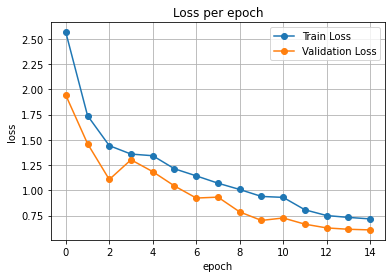

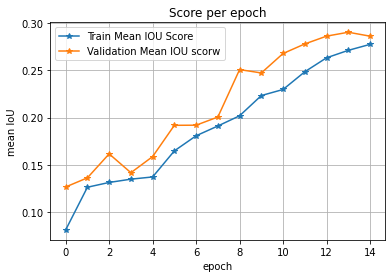

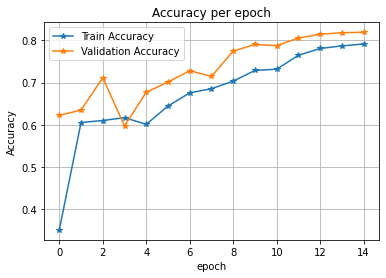

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Testing:

In [ ]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_data = DroneTestDataset(IMAGE_PATH, MASK_PATH, test_data, transform=t_test)

# Evaluation Model:

In [ ]:
def predict_mask(model, image, mask, method, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
  model.eval()
  t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
  image = t(image)
  model = model.to(device)
  image = image.to(device)
  mask = mask.to(device)

  with torch.no_grad():
    image = image.unsqueeze(0)
    mask = mask.unsqueeze(0)

    output = model(image)
    pred_mask = torch.argmax(output, dim = 1)
    pred_mask = pred_mask.cpu().squeeze(0)

    if method == "IOU":
      iou = IOU(output, mask)
      return pred_mask, iou
    else:
      accuracy = pixel_accuracy(output, mask)
      return pred_mask, accuracy

In [ ]:
image, mask = test_data[3]
pred_mask, score = predict_mask(model, image, mask, "IOU")

In [ ]:
def get_IOU(model, test_data):
  iou_scores = []
  for i in tqdm(range(len(test_data))):
    img, mask = test_data[i]
    pred_mask, iou = predict_mask(model, image, mask, "IOU")
    iou_scores.append(iou)
  return iou_scores

In [ ]:
def get_acc(model, test_data):
  test_accuracies = []
  for i in tqdm(range(len(test_data))):
    img, mask = test_data[i]
    pred_mask, acc = predict_mask(model, image, mask, "acc")
    test_accuracies.append(acc)
  return test_accuracies

# Evaluation Scores:

In [ ]:
test_iou = get_IOU(model, test_data)

In [ ]:
test_accuracies = get_acc(model, test_data)

In [ ]:
print(test_iou)

[0.01437535951719747, 0.027830104889198723, 0.037636654296100636, 0.25745239332164954, 0.01871943365269572, 0.017298327172982738, 0.03736476105629891, 0.005231125780209341, 0.035912419566468096, 0.027395614450115548, 0.020896997684584376, 0.01534604112031907, 0.019398139810491277, 0.08172611029700651, 0.017125933014554395, 0.038136607168503464, 0.022494418133496872, 0.1395507160177836, 0.023869266268821677, 0.0065359467430306005, 0.016098082668007146, 0.008548186507378406, 0.05634263314335873, 0.00503594197293651, 0.13908541079210796, 0.008873851958658951, 0.007836094440955142, 0.020415742697034278, 0.04428648278972053, 0.04168202041351731, 0.015268589352858526, 0.02995368381372454, 0.004300687218607729, 0.09300447739131312, 0.02249949342753367, 0.03342576758717754, 0.03642942745751209, 0.053024850787353174, 0.010253906154186278, 0.028581277417296734, 0.0054334406081649345, 0.0148653226119955, 0.015125707164288456, 0.030925506458630642, 0.06141431136188718, 0.021227309533169616, 0.0099

In [ ]:
print(test_accuracies)

[0.01792286060474537, 0.3805259422019676, 0.28908397533275465, 0.8111504448784722, 0.1204562717013889, 0.04457035771122685, 0.1468539767795139, 0.019343623408564815, 0.24922914858217593, 0.16033144350405093, 0.024713586877893517, 0.1503058539496528, 0.08980871129918981, 0.5552786367910879, 0.02840056242766204, 0.31337031611689814, 0.06762469256365741, 0.6895073784722222, 0.1737377025462963, 0.019058792679398147, 0.05931034794560185, 0.022424768518518517, 0.3587601273148148, 0.01801667390046296, 0.6842515733506944, 0.01859424732349537, 0.06681202076099536, 0.1842673972800926, 0.37171314380787035, 0.26480667679398145, 0.031141493055555556, 0.1854214138454861, 0.035799379701967594, 0.5279981825086806, 0.033122875072337965, 0.044689037181712965, 0.2813822428385417, 0.41257618091724535, 0.015316433376736112, 0.23093103479456017, 0.019439697265625, 0.05400028935185185, 0.18082569263599538, 0.26450150101273145, 0.4138658311631944, 0.044718424479166664, 0.028166594328703703, 0.0795107241030092

In [ ]:
print(np.mean(test_iou))

0.036112448135265804


In [ ]:
print(np.mean(test_accuracies))

0.19052553530092592


# Predict Images

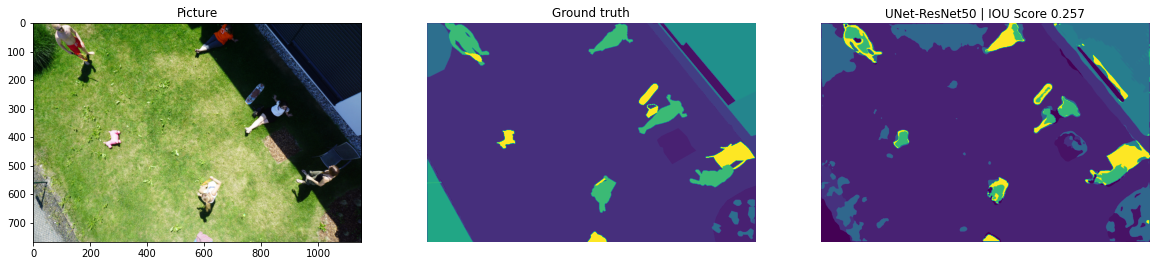

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-ResNet50 | IOU Score {:.3f}'.format(score))
ax3.set_axis_off()

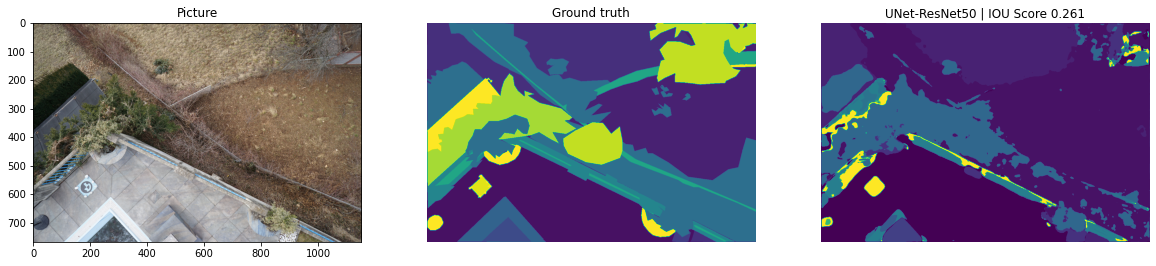

In [ ]:
image2, mask2 = test_data[4]
pred_mask2, score2 = predict_mask(model, image2, mask2, "IOU")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
# ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_title('UNet-ResNet50 | IOU Score {:.3f}'.format(score2))
ax3.set_axis_off()

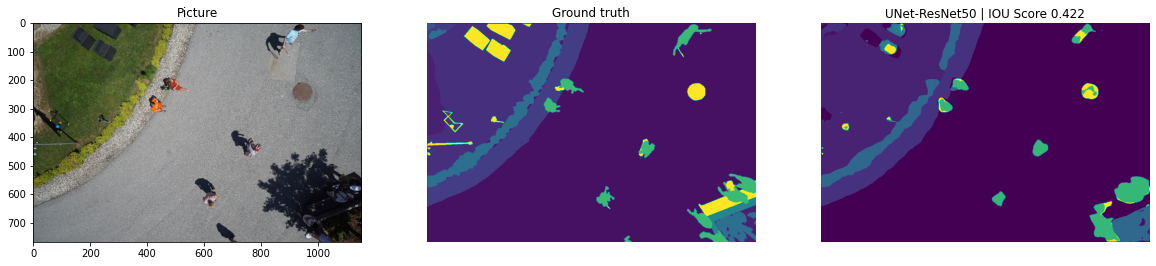

In [ ]:
image3, mask3 = test_data[6]
pred_mask3, score3 = predict_mask(model, image3, mask3, "IOU")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-ResNet50 | IOU Score {:.3f}'.format(score3))

ax3.set_axis_off()